In [89]:
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [112]:
!unzip "/content/test-videos.zip"

Archive:  /content/test-videos.zip
   creating: test-videos/
  inflating: test-videos/mona-lisa-blur-extra-credit.avi  
  inflating: test-videos/mona-lisa-blur.avi  
  inflating: test-videos/mona-lisa.avi  
  inflating: test-videos/simple_track.avi  


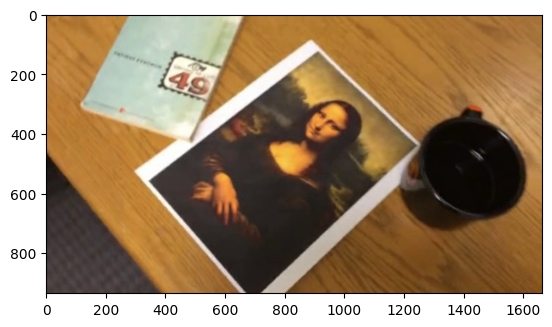

In [61]:
img = cv2.imread("test.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

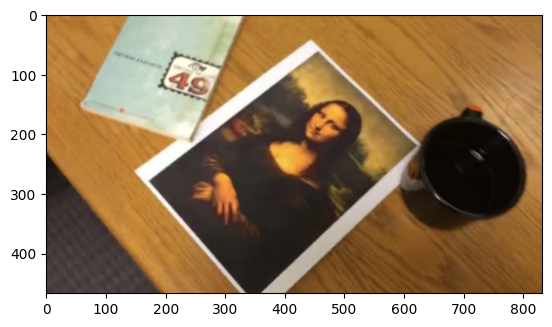

In [62]:
resized = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2))
plt.imshow(resized)
plt.show()

In [4]:
img.shape[0] // 2

467

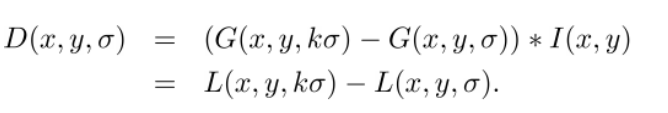

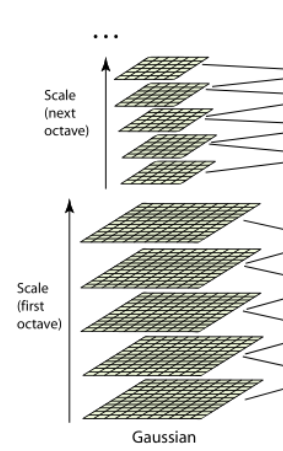

In [45]:
def build_gaussian_pyramid(img, num_octaves=4, num_levels=3, sigma0=1.6):
    current_img = img.astype(np.float32)

    base_sigma = np.sqrt(max(sigma0 ** 2 - 0.5 ** 2, 0.01))
    current_img = cv2.GaussianBlur(current_img, (0, 0), sigmaX=base_sigma)

    k = 2 ** (1.0 / num_levels)
    pyramid = []

    for octave in range(num_octaves):
        h, w = current_img.shape[:2]
        if min(h, w) < 32:
            break

        octave_images = []
        sigma = sigma0
        for lvl in range(num_levels + 3):  # +3 для DoG и экстремумов
            # Гауссово размытие
            blurred = cv2.GaussianBlur(current_img, (0, 0), sigmaX=sigma)
            octave_images.append(blurred)
            sigma *= k

        min_h = min(img.shape[0] for img in octave_images)
        min_w = min(img.shape[1] for img in octave_images)
        octave_images = [img[:min_h, :min_w] for img in octave_images]

        pyramid.append(octave_images)
        next_base = octave_images[num_levels]

        new_h = next_base.shape[0] // 2
        new_w = next_base.shape[1] // 2

        if new_h < 32 or new_w < 32:
            break

        current_img = cv2.resize(next_base, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    return pyramid

In [52]:
def build_diff_of_gauss(pyramid):
    dog_pyramid = []
    for octave in pyramid:
        dog_octave = [octave[i+1] - octave[i] for i in range(len(octave)-1)]
        dog_pyramid.append(dog_octave)
    return dog_pyramid

In [64]:
if len(img.shape) == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img.astype(np.float32)

In [65]:
imgs = build_gaussian_pyramid(img)
imgs_dog = build_diff_of_gauss(imgs)

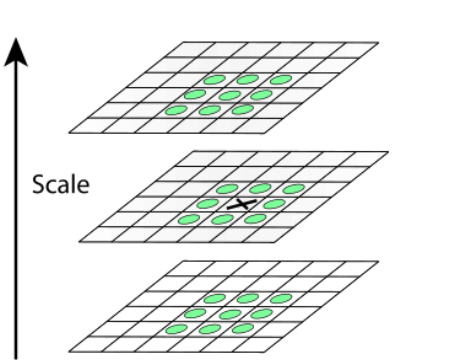

In [66]:
def find_dog_extrema(dog_pyramid, threshold=0.0):
    extrema = []
    octave_start_idx = 0
    for i in range(1, len(dog_pyramid) - 1):
        current_dog = dog_pyramid[i]
        prev_dog = dog_pyramid[i-1]
        next_dog = dog_pyramid[i+1]

        h, w = current_dog.shape
        for y in range(1, h-1):
            for x in range(1, w-1):
                center_val = current_dog[y, x]
                if abs(center_val) < threshold:
                    continue
                neighbors = []
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        if dy == 0 and dx == 0:
                            continue
                        neighbors.append(current_dog[y + dy, x + dx])
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        neighbors.append(prev_dog[y + dy, x + dx])
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        neighbors.append(next_dog[y + dy, x + dx])
                is_max = all(center_val > n for n in neighbors)
                is_min = all(center_val < n for n in neighbors)

                if is_max or is_min:
                    extrema.append({
                        'level_index': i,
                        'y': y,
                        'x': x,
                        'value': center_val,
                        'is_max': is_max,
                        'is_min': is_min
                    })

    return extrema

In [67]:
def compute_derivatives(dog_pyramid, x, y, s):
    D_prev = dog_pyramid[s - 1]
    D_curr = dog_pyramid[s]
    D_next = dog_pyramid[s + 1]

    # Первые производные
    Dx = (D_curr[y, x + 1] - D_curr[y, x - 1]) / 2.0
    Dy = (D_curr[y + 1, x] - D_curr[y - 1, x]) / 2.0
    Ds = (D_next[y, x] - D_prev[y, x]) / 2.0
    g = np.array([Dx, Dy, Ds])

    # Вторые производные (диагональ гессиана)
    Dxx = D_curr[y, x + 1] - 2 * D_curr[y, x] + D_curr[y, x - 1]
    Dyy = D_curr[y + 1, x] - 2 * D_curr[y, x] + D_curr[y - 1, x]
    Dss = D_next[y, x] - 2 * D_curr[y, x] + D_prev[y, x]

    # Смешанные производные
    Dxy = (D_curr[y + 1, x + 1] - D_curr[y + 1, x - 1] - D_curr[y - 1, x + 1] + D_curr[y - 1, x - 1]) / 4.0
    Dxs = (D_next[y, x + 1] - D_next[y, x - 1] - D_prev[y, x + 1] + D_prev[y, x - 1]) / 4.0
    Dys = (D_next[y + 1, x] - D_next[y - 1, x] - D_prev[y + 1, x] + D_prev[y - 1, x]) / 4.0

    # Гессиан 3x3
    H = np.array([
        [Dxx, Dxy, Dxs],
        [Dxy, Dyy, Dys],
        [Dxs, Dys, Dss]
    ])

    return g, H

def refine_keypoint_location(dog_pyramid, x, y, s, max_iterations=5, contrast_threshold=0.04, edge_threshold=10.0):
    x_sub = float(x)
    y_sub = float(y)
    s_sub = float(s)

    for _ in range(max_iterations):
        xi = int(round(x_sub))
        yi = int(round(y_sub))
        si = int(round(s_sub))

        if si <= 0 or si >= len(dog_pyramid) - 1:
            return None, None, None, False

        h, w = dog_pyramid[si].shape
        if yi < 1 or yi >= h - 1 or xi < 1 or xi >= w - 1:
            return None, None, None, False

        g, H = compute_derivatives(dog_pyramid, xi, yi, si)

        try:
            H_inv = np.linalg.inv(H)
        except np.linalg.LinAlgError:
            return None, None, None, False

        offset = -H_inv @ g  # [dx, dy, ds]

        if np.all(np.abs(offset) < 0.5):
            D_x = dog_pyramid[si][yi, xi]
            D_sub = D_x + 0.5 * g @ offset

            if abs(D_sub) < contrast_threshold:
                return None, None, None, False

            H_2x2 = H[:2, :2]
            det = np.linalg.det(H_2x2)
            if det <= 0:
                return None, None, None, False

            tr = np.trace(H_2x2)
            r = edge_threshold
            if (tr * tr) / det > ((r + 1) ** 2) / r:
                return None, None, None, False

            return xi + offset[0], yi + offset[1], si + offset[2], True

        x_sub = xi + offset[0]
        y_sub = yi + offset[1]
        s_sub = si + offset[2]

        if s_sub <= 0.5 or s_sub >= len(dog_pyramid) - 0.5:
            return None, None, None, False

        try:
            h, w = dog_pyramid[int(round(s_sub))].shape
        except IndexError:
            return None, None, None, False

        if x_sub < 0 or x_sub >= w or y_sub < 0 or y_sub >= h:
            return None, None, None, False
    return None, None, None, False

In [68]:
imgs_dog_gray = []
for img in imgs_dog:
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img
    imgs_dog_gray.append(img_gray.astype(np.float32))

AttributeError: 'list' object has no attribute 'shape'

In [69]:
extr = find_dog_extrema(imgs_dog_gray)

In [70]:
print("Проверка DoG-пирамиды:")
for i, img in enumerate(imgs_dog_gray):
    print(f"  Уровень {i}: shape = {img.shape}")

Проверка DoG-пирамиды:


In [71]:
refined_keypoints = []

for pt in extr:
    x, y, s = pt['x'], pt['y'], pt['level_index']
    x_sub, y_sub, s_sub, valid = refine_keypoint_location(
        imgs_dog_gray,
        x, y, s,
        contrast_threshold=0.04,
        edge_threshold=10.0
    )
    if valid:
        refined_keypoints.append({
            'x': x_sub,
            'y': y_sub,
            'scale_level': s_sub,
            # 'value': imgs_dog[0][int(s_sub)][int(y_sub), int(x_sub)] if s_sub is not None else 0
        })

print(f"✅ Пройдено: {len(refined_keypoints)} из {len(extr)} точек")

✅ Пройдено: 0 из 0 точек


In [ ]:
refined_keypoints

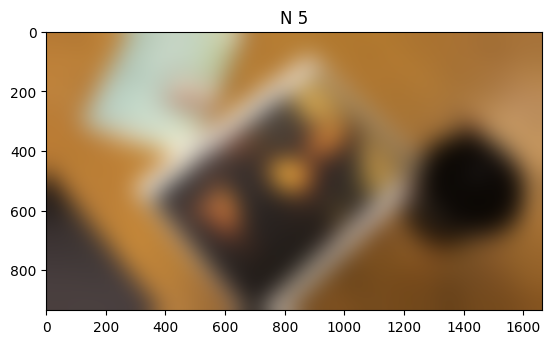

In [11]:
blurred = cv2.GaussianBlur(img, (0, 0), sigmaX=40.0)

blurred_uint8 = np.clip(blurred, 0, 255).astype(np.uint8)
plt.imshow(blurred_uint8, cmap='gray')
plt.title("N 5")
plt.show()

In [105]:
import cv2
import numpy as np

class SIFT:
    def find_point(self, img):
        refined_keypoints = []

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgs = self._build_gaussian_pyramid(img)
        imgs_dog = self._build_diff_of_gauss(imgs)

        imgs_dog_gray = []
        for dog_octave in imgs_dog:
            octave_gray = []
            for img in dog_octave:
                octave_gray.append(img.astype(np.float32))
            imgs_dog_gray.append(octave_gray)

        extr = self._find_dog_extrema(imgs_dog_gray)

        for pt in extr:
            x, y, octave_idx, scale_in_octave = pt['x'], pt['y'], pt['octave'], pt['scale_in_octave']

            dog_octave = imgs_dog_gray[octave_idx]

            x_sub, y_sub, s_sub, valid = self._refine_keypoint_location(
                dog_octave,
                x, y, scale_in_octave,
                contrast_threshold=0.04,
                edge_threshold=10.0
            )
            if valid:
                refined_keypoints.append({
                    'x': x_sub,
                    'y': y_sub,
                    'octave': octave_idx,
                    'scale_level': s_sub,
                })

        return refined_keypoints

    def _build_gaussian_pyramid(self, img, num_octaves=4, num_levels=3, sigma0=1.6):
        current_img = img.astype(np.float32)

        base_sigma = np.sqrt(max(sigma0 ** 2 - 0.5 ** 2, 0.01))
        current_img = cv2.GaussianBlur(current_img, (0, 0), sigmaX=base_sigma)

        k = 2 ** (1.0 / num_levels)
        pyramid = []

        for octave in range(num_octaves):
            h, w = current_img.shape[:2]
            if min(h, w) < 32:
                break

            octave_images = []
            sigma = sigma0
            for lvl in range(num_levels + 3):
                blurred = cv2.GaussianBlur(current_img, (0, 0), sigmaX=sigma)
                octave_images.append(blurred)
                sigma *= k

            pyramid.append(octave_images)
            next_base = octave_images[num_levels]

            new_h = next_base.shape[0] // 2
            new_w = next_base.shape[1] // 2

            if new_h < 128 or new_w < 128:
                break

            current_img = cv2.resize(next_base, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        return pyramid

    def _build_diff_of_gauss(self, pyramid):
        dog_pyramid = []
        for octave_idx in range(len(pyramid)):
            octave = pyramid[octave_idx]
            dog_octave = []
            for n in range(len(octave) - 1):
                dog = octave[n + 1] - octave[n]
                dog_octave.append(dog)
            dog_pyramid.append(dog_octave)
        return dog_pyramid

    def _compute_derivatives(self, dog_octave, x, y, s):
        D_prev = dog_octave[s - 1]
        D_curr = dog_octave[s]
        D_next = dog_octave[s + 1]

        # First derivatives
        Dx = (D_curr[y, x + 1] - D_curr[y, x - 1]) / 2.0
        Dy = (D_curr[y + 1, x] - D_curr[y - 1, x]) / 2.0
        Ds = (D_next[y, x] - D_prev[y, x]) / 2.0
        g = np.array([Dx, Dy, Ds])

        # Second derivatives (Hessian diagonal)
        Dxx = D_curr[y, x + 1] - 2 * D_curr[y, x] + D_curr[y, x - 1]
        Dyy = D_curr[y + 1, x] - 2 * D_curr[y, x] + D_curr[y - 1, x]
        Dss = D_next[y, x] - 2 * D_curr[y, x] + D_prev[y, x]

        # Mixed derivatives
        Dxy = (D_curr[y + 1, x + 1] - D_curr[y + 1, x - 1] - D_curr[y - 1, x + 1] + D_curr[y - 1, x - 1]) / 4.0
        Dxs = (D_next[y, x + 1] - D_next[y, x - 1] - D_prev[y, x + 1] + D_prev[y, x - 1]) / 4.0
        Dys = (D_next[y + 1, x] - D_next[y - 1, x] - D_prev[y + 1, x] + D_prev[y - 1, x]) / 4.0

        # 3x3 Hessian
        H = np.array([
            [Dxx, Dxy, Dxs],
            [Dxy, Dyy, Dys],
            [Dxs, Dys, Dss]
        ])

        return g, H

    def _refine_keypoint_location(self, dog_octave, x, y, s, max_iterations=5,
                                  contrast_threshold=0.04, edge_threshold=10.0):
        x_sub = float(x)
        y_sub = float(y)
        s_sub = float(s)

        for _ in range(max_iterations):
            xi = int(round(x_sub))
            yi = int(round(y_sub))
            si = int(round(s_sub))

            if si <= 0 or si >= len(dog_octave) - 1:
                return None, None, None, False

            h, w = dog_octave[si].shape
            if yi < 1 or yi >= h - 1 or xi < 1 or xi >= w - 1:
                return None, None, None, False

            g, H = self._compute_derivatives(dog_octave, xi, yi, si)

            try:
                H_inv = np.linalg.inv(H)
            except np.linalg.LinAlgError:
                return None, None, None, False

            offset = -H_inv @ g

            # Check convergence before updating
            if np.all(np.abs(offset) < 0.5):
                D_x = dog_octave[si][yi, xi]
                D_sub = D_x + 0.5 * g @ offset

                # Contrast check
                if abs(D_sub) < contrast_threshold:
                    return None, None, None, False

                # Edge response check
                H_2x2 = H[:2, :2]
                det = np.linalg.det(H_2x2)
                if det <= 0:
                    return None, None, None, False

                tr = np.trace(H_2x2)
                r = edge_threshold
                if (tr * tr) / det > ((r + 1) ** 2) / r:
                    return None, None, None, False

                return xi + offset[0], yi + offset[1], si + offset[2], True

            x_sub = xi + offset[0]
            y_sub = yi + offset[1]
            s_sub = si + offset[2]

            if s_sub <= 0.5 or s_sub >= len(dog_octave) - 0.5:
                return None, None, None, False

            try:
                h, w = dog_octave[int(round(s_sub))].shape
            except IndexError:
                return None, None, None, False

            if x_sub < 0 or x_sub >= w or y_sub < 0 or y_sub >= h:
                return None, None, None, False

        return None, None, None, False

    def _find_dog_extrema(self, dog_pyramid, threshold=0.0):
        keypoints = []
        for octave_idx, dog_octave in enumerate(dog_pyramid):
            if len(dog_octave) < 3:
                continue

            for s in range(1, len(dog_octave) - 1):
                curr = dog_octave[s]
                prev = dog_octave[s - 1]
                next_dog = dog_octave[s + 1]

                if not (curr.shape == prev.shape == next_dog.shape):
                    min_h = min(curr.shape[0], prev.shape[0], next_dog.shape[0])
                    min_w = min(curr.shape[1], prev.shape[1], next_dog.shape[1])
                    curr = curr[:min_h, :min_w]
                    prev = prev[:min_h, :min_w]
                    next_dog = next_dog[:min_h, :min_w]

                h, w = curr.shape
                if h < 3 or w < 3:
                    continue

                for y in range(1, h - 1):
                    for x in range(1, w - 1):
                        center_val = curr[y, x]
                        if abs(center_val) < threshold:
                            continue

                        neighbors = []
                        for ds in (-1, 0, 1):
                            for dy in (-1, 0, 1):
                                for dx in (-1, 0, 1):
                                    if ds == 0 and dy == 0 and dx == 0:
                                        continue
                                    try:
                                        if ds == -1:
                                            val = prev[y + dy, x + dx]
                                        elif ds == 0:
                                            val = curr[y + dy, x + dx]
                                        else:
                                            val = next_dog[y + dy, x + dx]
                                        neighbors.append(val)
                                    except IndexError:
                                        continue

                        if not neighbors:
                            continue

                        is_max = all(center_val > n for n in neighbors)
                        is_min = all(center_val < n for n in neighbors)

                        if is_max or is_min:
                            keypoints.append({
                                'x': x,
                                'y': y,
                                'octave': octave_idx,
                                'scale_in_octave': s
                            })
        return keypoints

In [106]:
img = cv2.imread("test.png")
kp = SIFT().find_point(img)

In [107]:
print(f"Found {len(kp)} keypoints")

Found 5089 keypoints


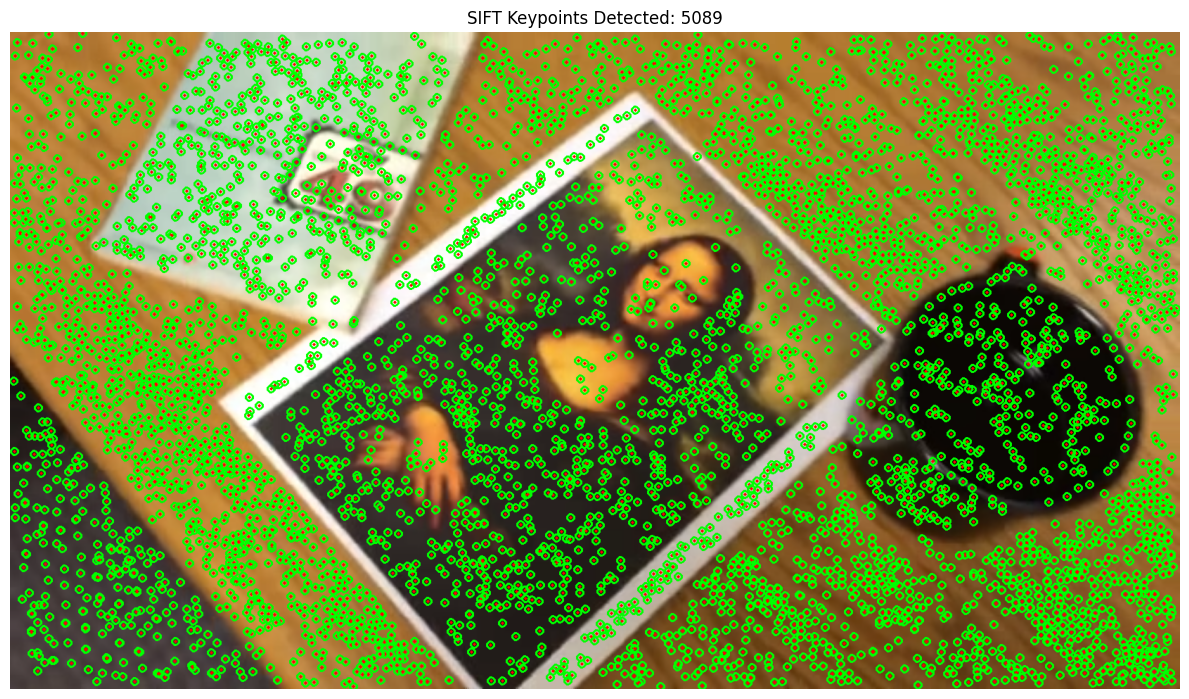

In [108]:
img_with_kp = img.copy()
for point in kp:
    x = int(point['x'] * (2 ** point['octave']))  # Scale back to original image size
    y = int(point['y'] * (2 ** point['octave']))
    cv2.circle(img_with_kp, (x, y), 5, (0, 255, 0), 2)
    cv2.circle(img_with_kp, (x, y), 2, (0, 0, 255), -1)

# Display result
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.title(f'SIFT Keypoints Detected: {len(kp)}')
plt.axis('off')
plt.tight_layout()
plt.show()

Showing top 150 keypoints


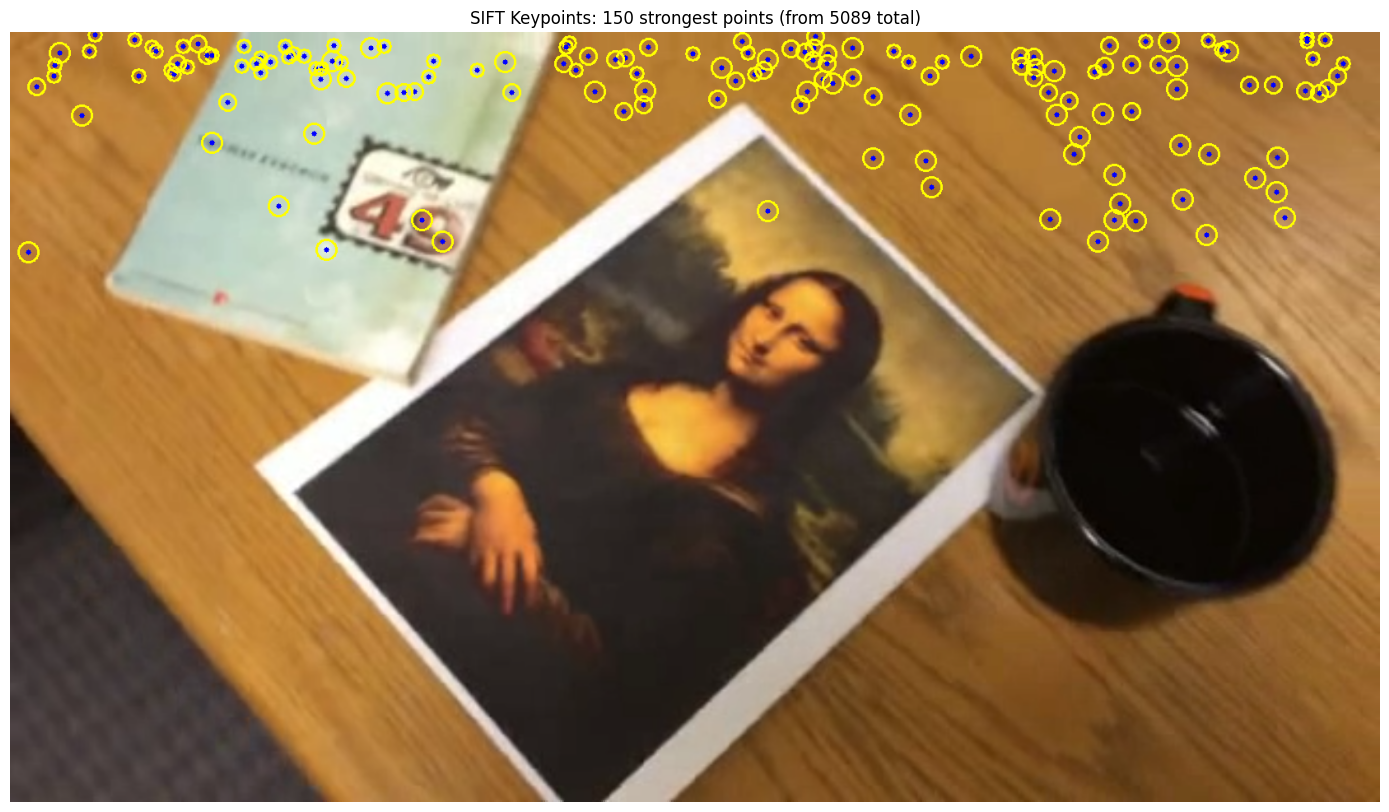

In [109]:
kp_per_octave = {}
for point in kp:
    octave = point['octave']
    if octave not in kp_per_octave:
        kp_per_octave[octave] = []
    kp_per_octave[octave].append(point)

# Take top keypoints from each octave
top_kp = []
max_per_octave = 50  # Adjust this to show more/fewer points
for octave, points in kp_per_octave.items():
    top_kp.extend(points[:max_per_octave])

print(f"Showing top {len(top_kp)} keypoints")

# Visualize keypoints
img_with_kp = img.copy()
for point in top_kp:
    x = int(point['x'] * (2 ** point['octave']))
    y = int(point['y'] * (2 ** point['octave']))

    h, w = img.shape[:2]
    if 0 <= x < w and 0 <= y < h:
        radius = 8 + point['octave'] * 2  # Larger circles for higher octaves
        cv2.circle(img_with_kp, (x, y), radius, (0, 255, 255), 2)
        cv2.circle(img_with_kp, (x, y), 3, (255, 0, 0), -1)

import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.title(f'SIFT Keypoints: {len(top_kp)} strongest points (from {len(kp)} total)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [114]:
def draw(img, keypoints, max_points=100):
    img_draw = img.copy()

    # Limit number of points to draw
    kp_to_draw = keypoints[:max_points]

    for pt in kp_to_draw:
        x = int(pt['x'])
        y = int(pt['y'])
        cv2.circle(img_draw, (x, y), 8, (0, 255, 255), 2)
        cv2.circle(img_draw, (x, y), 3, (255, 0, 0), -1)

    return img_draw

In [126]:
def parse_video(path2video, output_path, reference_image_path=None):
    import cv2
    import numpy as np
    import os

    cap = cv2.VideoCapture(path2video)
    if not cap.isOpened():
        return

    if reference_image_path is None:
        ret, img = cap.read()
        if not ret:
            cap.release()
            return
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    else:
        img = cv2.imread(reference_image_path)
        if img is None:
            ret, img = cap.read()
            if not ret:
                cap.release()
                return
            cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    kp = SIFT().find_point(img)

    h, w = img.shape[:2]
    reference_corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
    prev_points = np.array([[pt['x'], pt['y']] for pt in kp], dtype=np.float32).reshape(-1, 1, 2)

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps <= 0 or fps != fps:
        fps = 25
    fps = int(fps)

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    if not out.isOpened():
        cap.release()
        return

    ret, prev_frame = cap.read()
    if not ret:
        cap.release()
        out.release()
        return

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    lk_params = dict(
        winSize=(21, 21),
        maxLevel=3,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
    )

    current_corners = reference_corners.copy()
    frame_count = 0
    redetection_threshold = 10

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        next_points, status_fwd, _ = cv2.calcOpticalFlowPyrLK(
            prev_gray, curr_gray, prev_points, None, **lk_params
        )

        back_points, status_back, _ = cv2.calcOpticalFlowPyrLK(
            curr_gray, prev_gray, next_points, None, **lk_params
        )

        fb_error = np.abs(prev_points - back_points).reshape(-1, 2).max(-1)
        good_mask = (
            (status_fwd.ravel() == 1) &
            (status_back.ravel() == 1) &
            (fb_error < 1.0)
        )

        good_prev = prev_points[good_mask]
        good_next = next_points[good_mask]

        if len(good_prev) < redetection_threshold:
            kp_new = SIFT().find_point(frame)
            if len(kp_new) > 10:
                prev_points = np.array([[pt['x'], pt['y']] for pt in kp_new],
                                       dtype=np.float32).reshape(-1, 1, 2)
                current_corners = reference_corners.copy()
            out.write(frame)
            prev_gray = curr_gray.copy()
            continue

        if len(good_prev) >= 4:
            M, mask = cv2.findHomography(good_prev, good_next, cv2.RANSAC, 5.0)
            if M is not None:
                current_corners = cv2.perspectiveTransform(current_corners, M)
                pts = np.int32(current_corners).reshape(-1, 2)
                cv2.polylines(frame, [pts], True, (0, 255, 0), 3)

                if mask is not None:
                    prev_points = good_next[mask.ravel() == 1]
                else:
                    prev_points = good_next

        out.write(frame)
        prev_gray = curr_gray.copy()

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [127]:
parse_video(
    r"/content/test-videos/mona-lisa-blur.avi",
    r"/content/blur.avi",
    None
)

In [128]:
parse_video(
    r"/content/test-videos/mona-lisa-blur-extra-credit.avi",
    r"/content/blur-extra.avi",
    None
)

In [129]:
parse_video(
    r"/content/test-videos/mona-lisa.avi",
    r"/content/original.avi",
    None
)

In [130]:
parse_video(
    r"/content/our.avi",
    r"/content/our_post.avi",
    None
)